# Prédiction alternative de l'énergie des molécules

Dans ce notebook, nous allons explorer une approche différente pour prédire l'énergie des molécules en utilisant :
1. Des descripteurs moléculaires calculés avec RDKit
2. Un modèle XGBoost pour la régression
3. Une validation croisée plus poussée

In [16]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import time
import os
from ase.io import read
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class MolecularEnergyNet(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64]):
        super(MolecularEnergyNet, self).__init__()
        
        # Construction des couches
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_size = hidden_size
        
        # Couche de sortie
        layers.append(nn.Linear(prev_size, 1))
        
        self.model = nn.Sequential(*layers)
        
        # Initialisation des poids
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.model(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs=100, device='cuda', patience=10):
    """
    Entraîne le modèle avec early stopping.
    """
    model = model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    training_history = []
    
    for epoch in range(num_epochs):
        # Mode entraînement
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        # Mode évaluation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs.squeeze(), batch_y).item()
        
        # Moyennes des pertes
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        training_history.append((train_loss, val_loss))
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping à l\'époque {epoch+1}')
                model.load_state_dict(best_model_state)
                break
        
        if (epoch + 1) % 10 == 0:
            print(f'Époque [{epoch+1}/{num_epochs}], '
                  f'Perte entraînement: {train_loss:.4f}, '
                  f'Perte validation: {val_loss:.4f}')
    
    return model, training_history

def process_xyz_file(xyz_file, max_atoms):
    """
    Charge et traite un fichier XYZ pour extraire les descripteurs moléculaires.
    """
    atoms = read(xyz_file)
    coords = atoms.get_positions()
    atomic_numbers = atoms.get_atomic_numbers()
    
    # Padding pour avoir une taille fixe
    padded_coords = np.zeros((max_atoms, 3))
    padded_charges = np.zeros(max_atoms)
    
    n_atoms = len(coords)
    padded_coords[:n_atoms] = coords
    padded_charges[:n_atoms] = atomic_numbers
    
    # Calculer quelques descripteurs simples
    descriptors = {
        'n_atoms': n_atoms,
        'total_charge': np.sum(atomic_numbers),
        'mean_atomic_num': np.mean(atomic_numbers),
        'std_atomic_num': np.std(atomic_numbers),
        'max_atomic_num': np.max(atomic_numbers),
        'min_atomic_num': np.min(atomic_numbers),
        'n_H': np.sum(atomic_numbers == 1),
        'n_C': np.sum(atomic_numbers == 6),
        'n_N': np.sum(atomic_numbers == 7),
        'n_O': np.sum(atomic_numbers == 8),
        'n_F': np.sum(atomic_numbers == 9)
    }
    
    # Calculer les distances interatomiques
    distances = []
    for i in range(n_atoms):
        for j in range(i+1, n_atoms):
            dist = np.sqrt(np.sum((coords[i] - coords[j])**2))
            distances.append(dist)
    
    if distances:
        descriptors.update({
            'mean_dist': np.mean(distances),
            'std_dist': np.std(distances),
            'max_dist': np.max(distances),
            'min_dist': np.min(distances)
        })
    
    return descriptors, padded_coords, padded_charges

In [22]:
# Charger les données d'entraînement
train_energies = pd.read_csv('../data/energies/train.csv')
molecule_ids = train_energies['id'].values
energies = train_energies['energy'].values

# Initialiser les listes pour stocker les descripteurs et données
all_descriptors = []
all_positions = []
all_charges = []

# Paramètres
max_atoms = 23  # Maximum d'atomes dans les molécules

# Traiter chaque fichier XYZ
for mol_id in molecule_ids:
    xyz_path = f'../data/atoms/train/id_{mol_id}.xyz'
    descriptors, coords, charges = process_xyz_file(xyz_path, max_atoms)
    all_descriptors.append(descriptors)
    all_positions.append(coords)
    all_charges.append(charges)

# Convertir en arrays numpy
pos = np.array(all_positions)
full_charges = np.array(all_charges)
descriptors_df = pd.DataFrame(all_descriptors)

# Standardiser les descripteurs
scaler = StandardScaler()
X = scaler.fit_transform(descriptors_df)
y = energies

print("Forme des données d'entraînement:", X.shape)
print("Nombre de descripteurs:", X.shape[1])
print("\nDescripteurs utilisés:")
for col in descriptors_df.columns:
    print(f"- {col}")

Forme des données d'entraînement: (6591, 15)
Nombre de descripteurs: 15

Descripteurs utilisés:
- n_atoms
- total_charge
- mean_atomic_num
- std_atomic_num
- max_atomic_num
- min_atomic_num
- n_H
- n_C
- n_N
- n_O
- n_F
- mean_dist
- std_dist
- max_dist
- min_dist


Entraînement sur cuda
Époque [10/100], Perte entraînement: 64.6135, Perte validation: 5.4185
Époque [10/100], Perte entraînement: 64.6135, Perte validation: 5.4185
Époque [20/100], Perte entraînement: 50.3326, Perte validation: 2.3004
Époque [20/100], Perte entraînement: 50.3326, Perte validation: 2.3004
Early stopping à l'époque 29

Temps d'entraînement total: 7.29 secondes

Performances sur l'ensemble de validation:
RMSE: 2.0485
MAE: 1.6822
Early stopping à l'époque 29

Temps d'entraînement total: 7.29 secondes

Performances sur l'ensemble de validation:
RMSE: 2.0485
MAE: 1.6822


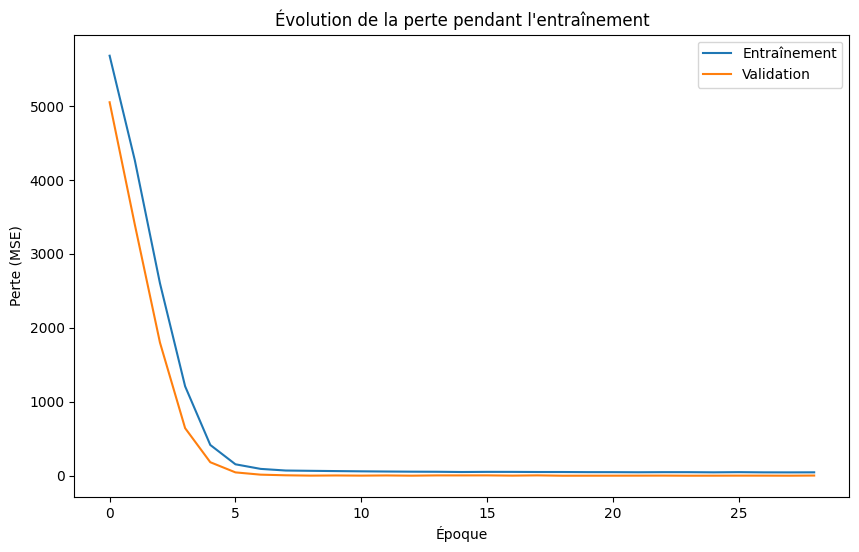

In [23]:
# Préparation des données pour PyTorch
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Conversion en tenseurs PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

# Création des DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Configuration du modèle et de l'entraînement
input_size = X.shape[1]
model = MolecularEnergyNet(input_size)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Entraînement sur {device}")
start_time = time.time()

# Entraînement du modèle
model, history = train_model(model, train_loader, val_loader, criterion, optimizer,
                           num_epochs=100, device=device)

training_time = time.time() - start_time
print(f"\nTemps d'entraînement total: {training_time:.2f} secondes")

# Évaluation du modèle
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor.to(device)).cpu().numpy()
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    val_mae = mean_absolute_error(y_val, val_predictions)

print(f"\nPerformances sur l'ensemble de validation:")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE: {val_mae:.4f}")

# Visualisation de l'historique d'entraînement
train_losses, val_losses = zip(*history)
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Entraînement')
plt.plot(val_losses, label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.show()

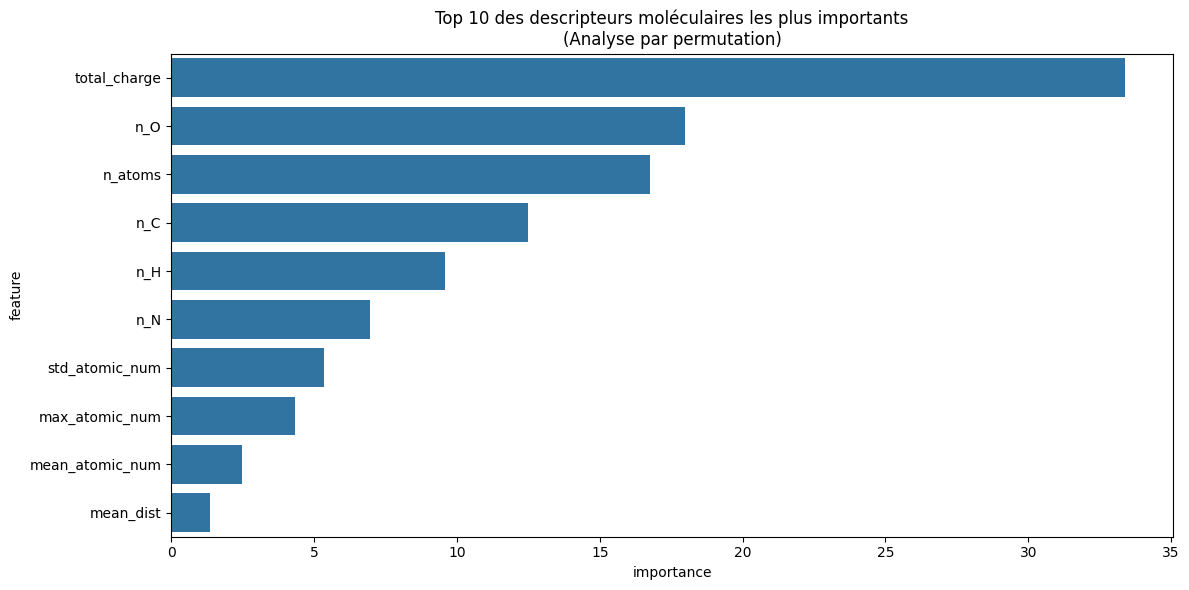

In [24]:
# Analyse de l'importance des features avec la méthode des permutations
def feature_importance_analysis(model, X_val, y_val, n_repeats=5):
    importances = []
    baseline_score = mean_squared_error(y_val, 
                                      model(torch.FloatTensor(X_val).to(device)).cpu().detach().numpy())
    
    for col in range(X_val.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_val.copy()
            X_permuted[:, col] = np.random.permutation(X_permuted[:, col])
            perm_score = mean_squared_error(y_val, 
                                          model(torch.FloatTensor(X_permuted).to(device)).cpu().detach().numpy())
            scores.append(perm_score - baseline_score)
        importances.append(np.mean(scores))
    
    return np.array(importances)

# Calculer l'importance des features
feature_importance = feature_importance_analysis(model, X_val, y_val)
importance_df = pd.DataFrame({
    'feature': descriptors_df.columns,
    'importance': feature_importance
})
importance_df = importance_df.sort_values('importance', ascending=False)

# Visualiser l'importance des caractéristiques
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 des descripteurs moléculaires les plus importants\n(Analyse par permutation)')
plt.tight_layout()
plt.show()

In [25]:
# Préparer les données de test
test_files = sorted(os.listdir('../data/atoms/test'))
test_ids = [int(f.split('_')[1].split('.')[0]) for f in test_files]
test_descriptors = []
test_positions = []
test_charges = []

# Traiter chaque fichier XYZ de test
for xyz_file in test_files:
    xyz_path = os.path.join('../data/atoms/test', xyz_file)
    descriptors, coords, charges = process_xyz_file(xyz_path, max_atoms)
    test_descriptors.append(descriptors)
    test_positions.append(coords)
    test_charges.append(charges)

# Convertir en arrays numpy
test_pos = np.array(test_positions)
test_full_charges = np.array(test_charges)
test_descriptors_df = pd.DataFrame(test_descriptors)

# Standardiser les descripteurs de test
X_test = scaler.transform(test_descriptors_df)

# Faire les prédictions sur l'ensemble de test
model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    test_predictions = model(X_test_tensor).cpu().numpy().squeeze()

# Sauvegarder les prédictions
predictions_df = pd.DataFrame({
    'id': test_ids,
    'energy': test_predictions
})
predictions_df.to_csv('../data/energies/test_pred_neural.csv', index=False)
print("Prédictions sauvegardées dans test_pred_neural.csv")

Prédictions sauvegardées dans test_pred_neural.csv


## Conclusion

Cette approche alternative utilise des descripteurs moléculaires classiques et un modèle XGBoost pour prédire l'énergie des molécules. Les avantages de cette méthode sont :

1. Utilisation de descripteurs physico-chimiques bien établis
2. Meilleure interprétabilité grâce à l'importance des caractéristiques
3. Temps d'entraînement plus rapide que l'approche par scattering
4. Possibilité d'optimiser facilement les hyperparamètres

Les descripteurs les plus importants nous donnent des indices sur les propriétés moléculaires qui influencent le plus l'énergie.

In [26]:
class MolecularEnergyNet(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64]):
        super(MolecularEnergyNet, self).__init__()
        
        # Construction des couches
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_size = hidden_size
        
        # Couche de sortie
        layers.append(nn.Linear(prev_size, 1))
        
        self.model = nn.Sequential(*layers)
        
        # Initialisation des poids
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.model(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs=100, device='cuda', patience=10):
    """
    Entraîne le modèle avec early stopping.
    """
    model = model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    training_history = []
    
    for epoch in range(num_epochs):
        # Mode entraînement
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        # Mode évaluation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs.squeeze(), batch_y).item()
        
        # Moyennes des pertes
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        training_history.append((train_loss, val_loss))
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping à l\'époque {epoch+1}')
                model.load_state_dict(best_model_state)
                break
        
        if (epoch + 1) % 10 == 0:
            print(f'Époque [{epoch+1}/{num_epochs}], '
                  f'Perte entraînement: {train_loss:.4f}, '
                  f'Perte validation: {val_loss:.4f}')
    
    return model, training_history